In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

In [2]:
os.chdir('C:/Users/dkornev/Desktop/Work Folder/My Folders/Harrisburg University/ISEM 780-52-A-2021 Fall - Doctoral Research Seminar/Experiment')
os.getcwd()

'C:\\Users\\dkornev\\Desktop\\Work Folder\\My Folders\\Harrisburg University\\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\\Experiment'

In [3]:
### Создание файла-триггера

In [4]:
def EVENTS(a):
    a = a.TL02.str.split(r'\t', expand=True) # dividing by columns; !!!the whole dataset is more than 200 trials (201)!!!
    a.columns = ['Time', 'Time1', 'Mark'] # rename columns
    a.drop('Time1', axis = 1, inplace = True) # drop colunm "0"

    # Sort decision time points (DTP) only and dividing by 10 Blocks
    igt1 = a[(a.Mark == '"PP 1"') | (a.Mark == '"PP 2"') | (a.Mark == '"PP 3"') | (a.Mark == '"PP 4"')]
    igt1.columns = ['DTP', 'Deck']
    igt1 = igt1.reset_index(drop = True)
    igt1['Block'] = pd.DataFrame(np.repeat(np.arange(0, 10), 20))
    
    # Sort reaction time points (RTP)
    # PP9 - win
    # PP10 - loss
    igt2 = a[(a.Mark == '"PP 9"') | (a.Mark == '"PP 10"')]
    igt2.columns = ['RTP', 'Result']
    igt2 = igt2.reset_index(drop = True)

    # The whole IGT dataset
    igt = igt1.join(igt2)
    igt = igt.dropna(axis=0, how='any') # erasing NaN rows
    igt = igt.drop_duplicates(keep='first', subset='RTP') # duplicates in rows deliting

    # Rename decks and results
    igt['RTP'] = igt['RTP'].astype(str).astype(int)
    igt['DTP'] = igt['DTP'].astype(str).astype(int)
    igt.loc[(igt.Deck == '"PP 1"'), 'Deck'] = 'A'
    igt.loc[(igt.Deck == '"PP 2"'), 'Deck'] = 'B'
    igt.loc[(igt.Deck == '"PP 3"'), 'Deck'] = 'C' 
    igt.loc[(igt.Deck == '"PP 4"'), 'Deck'] = 'D'
    igt.loc[(igt.Result == '"PP 9"'), 'Result'] = '1' 
    igt.loc[(igt.Result == '"PP 10"'), 'Result'] = '0'
    
        # Events (triggers) list creation
    igt['Tmax'] = igt['RTP'] + 800 # RTP is 0 point of trigger event, Tmax is the END point of the trigger event
    igt['Tmin'] = igt['RTP'] - 200 # RTP is 0 point of trigger event, Tmin is the START point of the trigger event
    events = igt[['Deck', 'Tmin', 'Tmax']]
    events = events.melt(id_vars=['Deck'], value_vars=['Tmin', 'Tmax'])
    events.drop('Deck', axis = 1, inplace = True)
    events.columns = ['point', 'time']
    events = events.sort_values(by=['time'])
    
    Tmin = events[(events.point == 'Tmin')]
    Tmax = events[(events.point == 'Tmax')]
    Tmax = Tmax.reset_index(drop = True)
    Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))
    Tmax['index'] = pd.DataFrame(np.arange(2001, 3001))
    events = pd.concat([Tmin, Tmax])
    events = events.reset_index(drop = True)
    events = events.sort_values(by=['time'])   
    # For following synchronization with EEG dataset EVENTS data should be adjusted by adding an appropriate columns
    
    # Set of triggers events (time window intervals) creation: 200 card selections by 1001 time points, total 200200 rows     
    intervals = pd.concat([pd.DataFrame([i], columns=['point']) for i in range(1001)]*200, ignore_index=True)
    intervals.loc[intervals.point == 0, 'point'] = '01Tmin'
    intervals.loc[intervals.point == 1000, 'point'] = '02Tmax'
    intervals['int'] = pd.DataFrame(np.arange(0, 200200)) 
    
    # Rename Tmin and Tmax points for following sorting
    intervals['point'] = intervals['point'].astype(str)
    
    # now we have the first 200 rows of Tmin (01Tmin) and the second 200 rows of Tmax (02Tmax) 
    # for following numbering simplification
    intervals = intervals.sort_values(by=['point', 'int'])
    intervals = intervals.reset_index(drop = True)
    
    # Adding new column "index" for numbering Tmin and Tmax
    A = [np.arange(1001, 1201)]
    B = [np.arange(2001, 2201)]
    AA = pd.DataFrame(A).T
    BB = pd.DataFrame(B).T
    C = pd.concat([AA, BB])
    C = C.reset_index(drop = True)
    intervals = intervals.join(C)
    intervals.columns = ['point', 'int', 'index']
    intervals = intervals.fillna(0)
    # Now we have individual indexes for each Tmin and Tmax
    
        # Sort back to 1 - 200200 by "int" column
    intervals = intervals.sort_values(by=['int'])
    intervals['index'] = intervals['index'].astype(int)
    
    # Rename points back
    intervals.loc[(intervals.point == '01Tmin'), 'point'] = 'Tmin' 
    intervals.loc[(intervals.point == '02Tmax'), 'point'] = 'Tmax'
    
     # Creation trigger events dataset
    
    events_triggers = intervals.merge(events, how = 'left', on = 'index') # merge EVENTS and INTERVALS
    
    events_triggers = events_triggers.reset_index(drop = True)
    events_triggers = events_triggers[['point_x', 'time']] # taking just two columns
    events_triggers.columns = ['intervals', 'time'] # renaming columns to "INTARVALS" and "TIME"

    events_triggers['time3'] = events_triggers['time']
    events_triggers['time3'].fillna(method='bfill', inplace=True) # filling NaN as the lower  number

    events_triggers = events_triggers.dropna(subset=['time3'])# drop NaN by the column

    events_triggers['time4'] = events_triggers['time']

    events_triggers = events_triggers.fillna(method='ffill') # filling NaN as the upper number

    events_triggers['intervals2'] = events_triggers['intervals']
    events_triggers.loc[(events_triggers.intervals2 == 'Tmin'), 'intervals2'] = '0' 
    events_triggers.loc[(events_triggers.intervals2 == 'Tmax'), 'intervals2'] = '0' 
    events_triggers['intervals2'] = events_triggers['intervals2'].astype(int)

    events_triggers['time5'] = events_triggers['time4'] + events_triggers['intervals2']
    events_triggers = events_triggers[['intervals', 'time5']]
    events_triggers.columns = ['intervals', 'time']
 
    return events_triggers

In [5]:
## Загрузка данных

In [6]:
igt01 = pd.read_csv('S1.edf.mrk')
igt17 = pd.read_csv('S17.edf.mrk')

In [7]:
igt01

,TL02
0,"79846\t 79846\t""PP 5"""
1,"82026\t 82026\t""PP 2"""
2,"84036\t 84036\t""PP 7"""
3,"87042\t 87042\t""PP 8"""
4,"88550\t 88550\t""PP 9"""
...,...
800,"1780784\t 1780784\t""PP 9"""
801,"1782346\t 1782346\t""PP 4"""
802,"1784365\t 1784365\t""PP 7"""
803,"1787372\t 1787372\t""PP 8"""


In [8]:
igt17

,TL02
0,"26330\t 26330\t""PP 5"""
1,"28190\t 28190\t""PP 4"""
2,"30203\t 30203\t""PP 7"""
3,"33209\t 33209\t""PP 8"""
4,"34717\t 34717\t""PP 9"""
...,...
802,"1977122\t 1977122\t""PP 9"""
803,"1981329\t 1981329\t""PP 4"""
804,"1983344\t 1983344\t""PP 7"""
805,"1986350\t 1986350\t""PP 8"""


In [9]:
# применение функции триггер-эвента
# файл триггеров содержит 200 интервалов, содержащих 1001 временную точку (с tmin до Tmax)

In [10]:
Events01 = EVENTS(igt01)
Events01

<ipython-input-4-b48076f2d393>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


,intervals,time
0,Tmin,88350.0
1,1,88351.0
2,2,88352.0
3,3,88353.0
4,4,88354.0
...,...,...
200195,996,1789675.0
200196,997,1789676.0
200197,998,1789677.0
200198,999,1789678.0


In [11]:
Events17 = EVENTS(igt17)
Events17

<ipython-input-4-b48076f2d393>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


,intervals,time
0,Tmin,34517.0
1,1,34518.0
2,2,34519.0
3,3,34520.0
4,4,34521.0
...,...,...
200195,996,1988654.0
200196,997,1988655.0
200197,998,1988656.0
200198,999,1988657.0


In [12]:
# загрузка данных EEG

In [13]:
file01 = './S1.edf'
file17 = './S17.edf'

In [14]:
eeg01 = mne.io.read_raw_edf(file01)
eeg17 = mne.io.read_raw_edf(file17)

Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [15]:
raw_df01 = eeg01.to_data_frame()
raw_df17 = eeg17.to_data_frame()

In [16]:
raw_df01

,time,Fp1,Fp2,F7,F3,Fz,F4,F8,FT9,FC5,...,P5,P1,P2,P6,PO7,PO3,POz,PO4,PO8,Oz
0,0,-68.436713,-57.297627,5.111772,-6.485084,-8.010986,0.839246,26.626993,60.044251,29.983978,...,16.708629,19.455253,25.253681,17.013809,29.221027,28.152895,16.250858,28.152895,6.637675,15.945678
1,1,-70.572976,-52.719921,9.536889,-2.975509,-5.569543,1.449607,32.120241,59.586481,31.052110,...,25.101091,18.997482,27.389944,19.302663,37.308309,33.035782,18.539712,27.847715,9.231708,18.387121
2,2,-80.949111,-53.788052,5.722133,-7.095445,-5.111772,-1.907378,33.951324,53.482872,29.526207,...,26.779583,12.893874,24.948501,17.776761,38.681621,34.103914,16.556039,24.643320,7.095445,15.487907
3,3,-94.377050,-58.060578,-3.585870,-14.572366,-3.891051,-6.942855,28.000305,45.395590,34.409094,...,22.507057,1.297017,18.234531,9.536889,28.152895,31.357290,10.757610,15.945678,-3.280690,7.095445
4,4,-101.396201,-60.196841,-9.842069,-20.523384,-4.654002,-10.910201,18.539712,40.970474,45.243000,...,23.575189,-1.449607,18.387121,8.316167,20.828565,34.103914,12.893874,13.656825,-4.043641,8.468757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843995,1843995,-41.123064,-33.951324,44.022278,-8.010986,3.128099,-11.673152,-32.730602,-31.052110,21.286336,...,50.888838,20.370794,22.812238,21.133745,71.488518,48.905165,29.983978,35.629816,-25.864042,42.496376
1843996,1843996,-39.902342,-29.678798,47.531853,-6.332494,4.196231,-10.605020,-32.272831,-23.727779,25.864042,...,57.907988,21.896696,26.016632,25.864042,78.355077,55.161364,36.087587,40.054932,-17.624170,50.736248
1843997,1843997,-38.376440,-30.136568,47.379263,-5.569543,1.602197,-11.825742,-28.915846,-24.185550,28.610666,...,62.485695,24.338140,30.594339,31.204700,84.458686,59.433890,43.259327,45.090410,-9.384298,59.891661
1843998,1843998,-35.782406,-32.272831,46.158541,-4.501411,-0.534066,-13.656825,-21.744106,-25.711452,31.815061,...,62.638285,28.152895,33.798734,33.798734,87.205310,59.891661,48.599985,48.142214,-6.332494,65.537499


In [17]:
raw_df01['level'] = raw_df01.mean(axis=1)
raw_df_mean01 = raw_df01['level']
raw_df_mean01 = raw_df_mean01.to_frame()
raw_df_mean01['time'] = raw_df_mean01.index
raw_df_mean01

,level,time
0,15.118169,0
1,17.610211,1
2,15.238145,2
3,9.100623,3
4,7.254407,4
...,...,...
1843995,28383.717996,1843995
1843996,28387.404936,1843996
1843997,28389.624662,1843997
1843998,28390.252755,1843998


In [18]:
raw_df17['level'] = raw_df17.mean(axis=1)
raw_df_mean17 = raw_df17['level']
raw_df_mean17 = raw_df_mean17.to_frame()
raw_df_mean17['time'] = raw_df_mean17.index
raw_df_mean17

,level,time
0,177.284011,0
1,136.346529,1
2,78.924608,2
3,9.112360,3
4,-63.178891,4
...,...,...
2002995,30764.612526,2002995
2002996,30778.476060,2002996
2002997,30797.368029,2002997
2002998,30816.250607,2002998


In [19]:
# объединение файла-триггера и EEG

In [20]:
S01 = raw_df_mean01.join(Events01.set_index('time'), on='time')
S01 = S01.dropna(axis=0, how='any') # erasing NaN rows
S01 = S01.reset_index(drop = True)
S01

,level,time,intervals
0,1362.120593,88350,Tmin
1,1359.804869,88351,1
2,1358.268528,88352,2
3,1359.157198,88353,3
4,1360.353397,88354,4
...,...,...,...
200195,27529.285262,1789675,996
200196,27529.533053,1789676,997
200197,27531.182327,1789677,998
200198,27530.916006,1789678,999


In [21]:
S01['epochs'] = pd.DataFrame(np.repeat(np.arange(0, 200), 1001))
S01.loc[(S01.intervals == 'Tmin'), 'intervals'] = '0' 
S01.loc[(S01.intervals == 'Tmax'), 'intervals'] = '1000' 
S01['intervals'] = S01['intervals'].astype(int)
S01

,level,time,intervals,epochs
0,1362.120593,88350,0,0
1,1359.804869,88351,1,0
2,1358.268528,88352,2,0
3,1359.157198,88353,3,0
4,1360.353397,88354,4,0
...,...,...,...,...
200195,27529.285262,1789675,996,199
200196,27529.533053,1789676,997,199
200197,27531.182327,1789677,998,199
200198,27530.916006,1789678,999,199


In [22]:
Spivot01 = S01.pivot(index='epochs', columns='intervals', values='level')
Spivot01

intervals,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
epochs,,,,,,,,,,,,,,,,,,,,,
0,1362.120593,1359.804869,1358.268528,1359.157198,1360.353397,1362.570775,1364.074502,1365.289480,1367.537377,1369.045798,...,1381.280099,1384.906003,1386.766556,1387.026085,1383.977927,1382.026072,1382.590781,1380.354873,1376.663489,1373.904079
1,1511.730969,1510.844898,1509.827364,1508.830958,1506.637306,1505.993031,1507.780810,1506.690502,1504.940536,1508.146230,...,1533.085427,1531.849572,1533.651436,1537.620081,1538.945394,1537.061617,1535.044030,1536.242576,1536.821371,1532.526669
2,1666.063602,1668.306804,1670.162661,1669.168603,1668.571279,1669.706441,1673.658653,1676.507521,1673.053239,1668.728018,...,1688.831280,1683.480184,1678.220642,1679.642204,1683.775177,1683.081604,1677.967610,1679.142680,1684.026866,1681.868427
3,1833.542938,1835.807268,1838.644398,1837.147966,1835.031782,1833.659770,1831.588190,1828.420307,1826.245435,1825.911036,...,1831.884443,1829.904417,1829.255448,1830.911764,1830.206453,1828.724106,1830.450849,1831.851283,1831.486366,1832.086289
4,1941.340691,1943.558069,1947.104157,1947.481063,1946.390755,1945.946022,1947.858220,1950.808032,1950.757686,1950.918618,...,1968.153183,1966.041695,1962.038088,1961.837498,1962.700346,1961.417540,1958.540753,1957.112399,1958.130184,1957.617372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,27018.861148,27018.108886,27020.626750,27022.170385,27019.044758,27018.283107,27020.293902,27019.705968,27017.721247,27017.581694,...,27031.306684,27030.822042,27032.072234,27033.810714,27033.666466,27032.463476,27033.420225,27037.034391,27037.847940,27036.004072
196,27155.348318,27152.710980,27150.341262,27150.072594,27149.759323,27151.279482,27152.884152,27151.915917,27150.701190,27151.491263,...,27166.638864,27167.025160,27168.463155,27167.743759,27164.075850,27164.757937,27165.810935,27165.051631,27164.663238,27162.495409
197,27274.853320,27269.720545,27271.674999,27273.098909,27274.372576,27273.392603,27272.440800,27276.158258,27277.544607,27275.250011,...,27298.212578,27294.291135,27294.135149,27297.944161,27302.734446,27301.965752,27299.828440,27302.966056,27301.133925,27298.057597


In [23]:
Spivot01_T = Spivot01.T
Spivot01_T

epochs,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
intervals,,,,,,,,,,,,,,,,,,,,,
0,1362.120593,1511.730969,1666.063602,1833.542938,1941.340691,2100.793650,2268.662231,2360.421658,2489.048114,2638.011471,...,26416.331757,26554.902092,26661.632447,26779.347463,26905.086949,27018.861148,27155.348318,27274.853320,27386.087866,27514.265018
1,1359.804869,1510.844898,1668.306804,1835.807268,1943.558069,2096.341662,2265.550690,2357.145789,2486.281662,2638.731118,...,26419.600835,26554.053581,26662.103254,26778.912120,26908.762152,27018.108886,27152.710980,27269.720545,27388.593993,27513.050290
2,1358.268528,1509.827364,1670.162661,1838.644398,1947.104157,2095.969703,2238.487179,2358.907745,2479.310762,2639.185493,...,26419.097412,26554.622986,26652.402163,26778.317144,26907.676539,27020.626750,27150.341262,27271.674999,27387.186767,27512.502265
3,1359.157198,1508.830958,1669.168603,1837.147966,1947.481063,2095.485061,2229.084226,2361.308232,2473.616925,2642.186951,...,26417.464823,26557.070424,26654.351922,26779.175296,26906.332697,27022.170385,27150.072594,27273.098909,27388.582506,27511.123210
4,1360.353397,1506.637306,1668.571279,1835.031782,1946.390755,2093.784392,2223.885720,2361.523158,2476.188782,2643.610861,...,26419.799579,26557.813546,26659.858207,26779.960674,26907.596974,27019.044758,27149.759323,27274.372576,27391.694298,27508.753492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1382.026072,1537.061617,1683.081604,1828.724106,1961.417540,2106.048120,2248.699407,2371.258583,2503.666928,2647.087739,...,26432.863818,26572.408383,26668.574799,26811.786468,26921.579102,27032.463476,27164.757937,27301.965752,27409.437189,27529.285262
997,1382.590781,1535.044030,1677.967610,1830.450849,1958.540753,2106.528318,2250.886267,2373.128526,2503.684661,2648.187688,...,26436.003781,26572.684345,26667.646472,26811.564750,26924.143917,27033.420225,27165.810935,27299.828440,27407.964232,27529.533053
998,1380.354873,1536.242576,1679.142680,1831.851283,1957.112399,2107.414640,2248.286490,2372.221326,2499.892332,2648.581027,...,26439.453619,26572.143362,26669.450683,26809.887557,26923.546593,27037.034391,27165.051631,27302.966056,27403.582670,27531.182327


In [24]:
Spivot01_T['Time'] = pd.DataFrame(np.arange(-200, 1000))
Spivot01_T = Spivot01_T.reset_index(drop = True)
Spivot01_T

epochs,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Time
0,1362.120593,1511.730969,1666.063602,1833.542938,1941.340691,2100.793650,2268.662231,2360.421658,2489.048114,2638.011471,...,26554.902092,26661.632447,26779.347463,26905.086949,27018.861148,27155.348318,27274.853320,27386.087866,27514.265018,-200
1,1359.804869,1510.844898,1668.306804,1835.807268,1943.558069,2096.341662,2265.550690,2357.145789,2486.281662,2638.731118,...,26554.053581,26662.103254,26778.912120,26908.762152,27018.108886,27152.710980,27269.720545,27388.593993,27513.050290,-199
2,1358.268528,1509.827364,1670.162661,1838.644398,1947.104157,2095.969703,2238.487179,2358.907745,2479.310762,2639.185493,...,26554.622986,26652.402163,26778.317144,26907.676539,27020.626750,27150.341262,27271.674999,27387.186767,27512.502265,-198
3,1359.157198,1508.830958,1669.168603,1837.147966,1947.481063,2095.485061,2229.084226,2361.308232,2473.616925,2642.186951,...,26557.070424,26654.351922,26779.175296,26906.332697,27022.170385,27150.072594,27273.098909,27388.582506,27511.123210,-197
4,1360.353397,1506.637306,1668.571279,1835.031782,1946.390755,2093.784392,2223.885720,2361.523158,2476.188782,2643.610861,...,26557.813546,26659.858207,26779.960674,26907.596974,27019.044758,27149.759323,27274.372576,27391.694298,27508.753492,-196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1382.026072,1537.061617,1683.081604,1828.724106,1961.417540,2106.048120,2248.699407,2371.258583,2503.666928,2647.087739,...,26572.408383,26668.574799,26811.786468,26921.579102,27032.463476,27164.757937,27301.965752,27409.437189,27529.285262,796
997,1382.590781,1535.044030,1677.967610,1830.450849,1958.540753,2106.528318,2250.886267,2373.128526,2503.684661,2648.187688,...,26572.684345,26667.646472,26811.564750,26924.143917,27033.420225,27165.810935,27299.828440,27407.964232,27529.533053,797
998,1380.354873,1536.242576,1679.142680,1831.851283,1957.112399,2107.414640,2248.286490,2372.221326,2499.892332,2648.581027,...,26572.143362,26669.450683,26809.887557,26923.546593,27037.034391,27165.051631,27302.966056,27403.582670,27531.182327,798
999,1376.663489,1536.821371,1684.026866,1831.486366,1958.130184,2107.538012,2246.419147,2374.532607,2498.600136,2647.788857,...,26571.677501,26672.043669,26810.602510,26920.080574,27037.847940,27164.663238,27301.133925,27406.339984,27530.916006,799


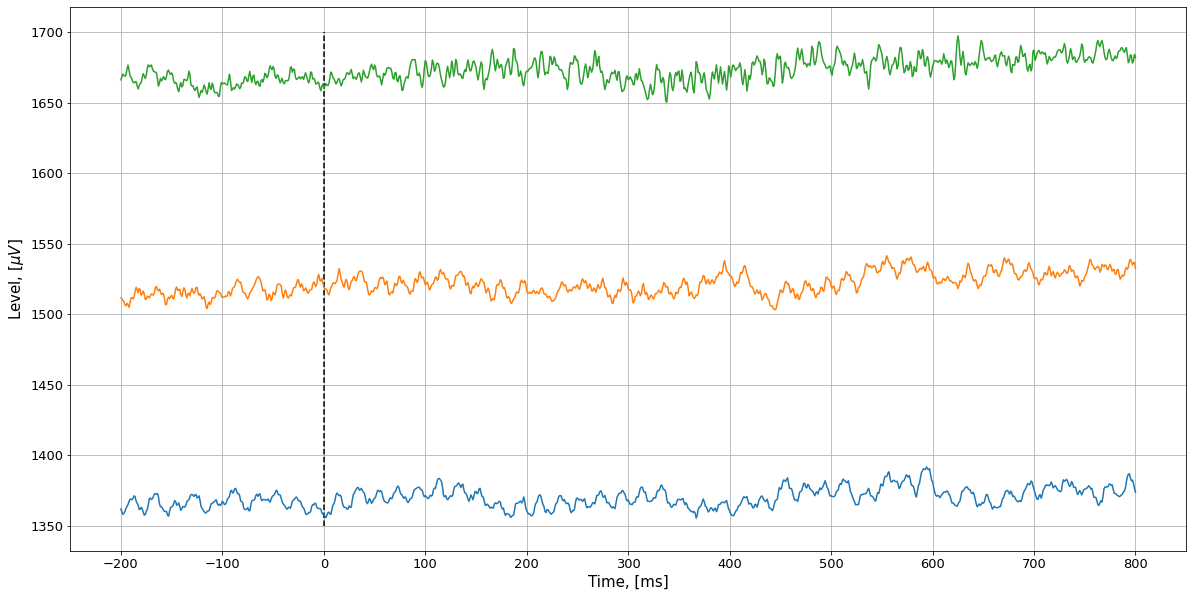

In [25]:
# plot before filtering for S01
plt.figure(figsize=(20, 10))

plt.plot(Spivot01_T['Time'], Spivot01_T[0])
plt.plot(Spivot01_T['Time'], Spivot01_T[1])
plt.plot(Spivot01_T['Time'], Spivot01_T[2])

plt.vlines(0, 1350, 1700, colors='black', linestyles='dashed')

plt.grid()
plt.xlabel('Time, [ms]', size='15')
plt.ylabel('Level, [$\mu V$]', size='15')

plt.yticks(fontsize=13)
plt.xticks(np.arange(-200, 801, step=100), fontsize=13)

plt.show()

In [26]:
S17 = raw_df_mean17.join(Events17.set_index('time'), on='time')
S17 = S17.dropna(axis=0, how='any')
S17 = S17.reset_index(drop = True)

S17['epochs'] = pd.DataFrame(np.repeat(np.arange(0, 200), 1001))
S17.loc[(S17.intervals == 'Tmin'), 'intervals'] = '0' 
S17.loc[(S17.intervals == 'Tmax'), 'intervals'] = '1000' 
S17['intervals'] = S17['intervals'].astype(int)

Spivot17 = S17.pivot(index='epochs', columns='intervals', values='level')
Spivot17_T = Spivot17.T

Spivot17_T['Time'] = pd.DataFrame(np.arange(-200, 1000))
Spivot17_T = Spivot17_T.reset_index(drop = True)
Spivot17_T

epochs,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Time
0,342.070085,510.939804,553.919125,717.796108,846.636498,1018.127043,1521.473196,1578.560758,1551.279537,1651.018296,...,29471.599991,29612.871760,29765.296829,29910.914207,30015.547319,30096.355595,30254.649616,30402.545503,30539.572402,-200
1,364.443458,554.603034,574.893363,742.338609,868.887799,968.459052,1500.463996,1627.045839,1623.394974,1721.039725,...,29466.976633,29608.518369,29744.280586,29932.367343,30034.988612,30107.688479,30263.294565,30382.487057,30547.449705,-199
2,405.493874,613.321050,601.574475,786.133302,902.921413,948.365394,1478.217642,1649.970885,1690.120455,1795.857183,...,29458.336630,29600.122511,29725.954627,29946.897579,30050.147989,30122.537980,30277.984433,30364.494449,30559.240359,-198
3,466.362237,683.640617,642.751658,846.623711,955.754141,964.611683,1442.271033,1639.269741,1746.796109,1856.187959,...,29448.677795,29590.930837,29713.236944,29953.953242,30062.553699,30146.139118,30299.268547,30351.293173,30578.186321,-197
4,536.869608,763.357394,697.903758,916.699134,1019.549889,990.450027,1386.656719,1616.690035,1781.550418,1896.691398,...,29436.561084,29579.077050,29708.219199,29956.457021,30068.236050,30169.869370,30321.287441,30345.655677,30599.515038,-196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,431.944048,497.188576,771.882013,801.667406,997.828254,1332.639631,1319.042988,1297.828293,1367.420732,1492.200720,...,29418.417102,29557.836660,29847.074120,29848.160390,29967.632314,30096.081604,30280.928671,30486.228998,30564.175312,796
997,367.657914,462.112905,693.681998,744.003688,929.006669,1273.029801,1399.510979,1349.050607,1391.935063,1514.752506,...,29438.248087,29578.937666,29841.908480,29853.575121,29975.612908,30086.110546,30268.006753,30478.936485,30548.919937,797
998,325.962175,462.196368,627.456795,704.690704,874.284421,1205.137843,1468.443149,1408.890748,1428.827983,1540.802129,...,29458.142456,29600.195956,29833.899967,29864.206090,29986.560795,30082.808854,30259.615590,30467.472390,30540.223594,798
999,314.469910,486.081558,583.608361,699.280920,848.267914,1129.860518,1514.568950,1486.461872,1480.677091,1587.829387,...,29475.024929,29614.836527,29822.698796,29878.769191,29998.828000,30089.007664,30256.609688,30452.639573,30540.501903,799


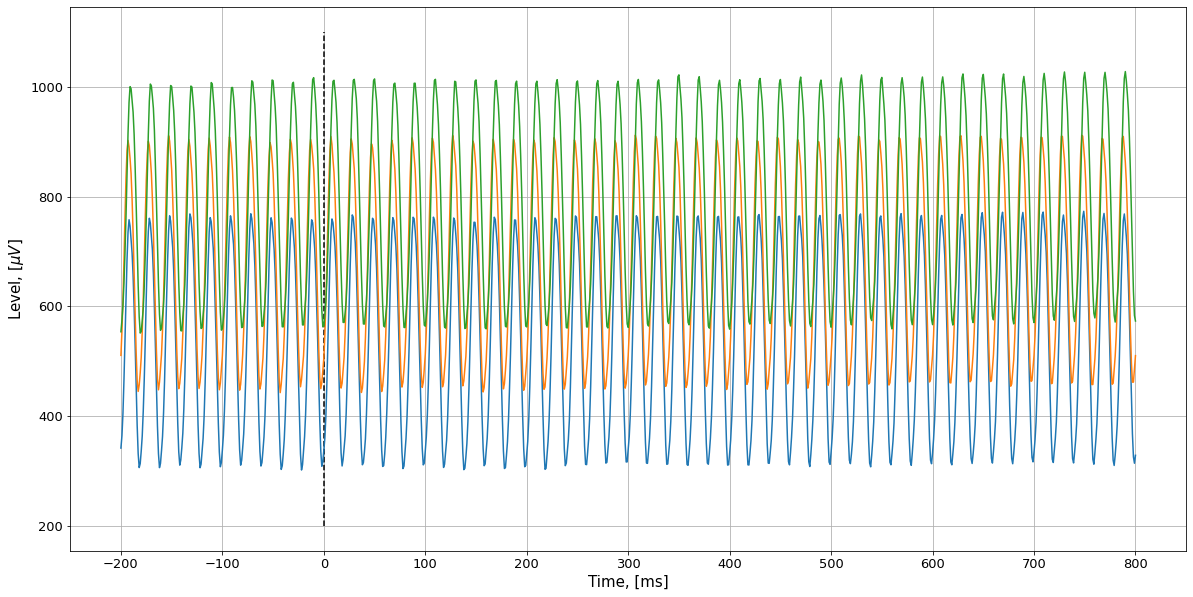

In [27]:
# plot before filtering for S17
plt.figure(figsize=(20, 10))

plt.plot(Spivot17_T['Time'], Spivot17_T[0])
plt.plot(Spivot17_T['Time'], Spivot17_T[1])
plt.plot(Spivot17_T['Time'], Spivot17_T[2])

plt.vlines(0, 200, 1100, colors='black', linestyles='dashed')

plt.grid()
plt.xlabel('Time, [ms]', size='15')
plt.ylabel('Level, [$\mu V$]', size='15')

plt.yticks(fontsize=13)
plt.xticks(np.arange(-200, 801, step=100), fontsize=13)

plt.show()

In [28]:
## filtering

In [29]:
eeg01.load_data()
raw_df01_f = eeg01.filter(1., 50., fir_design='firwin', skip_by_annotation='edge')

raw_df01_f = raw_df01_f.to_data_frame()
raw_df01_f.drop('time', axis = 1, inplace = True)
                         
mask = ((raw_df01 <= 50) & (raw_df01 >= -50)) # удаление данных более 50 uV и менее -50uV
raw_df01_f = raw_df01_f[mask]
raw_df01_f = raw_df01_f.fillna(method='ffill')
raw_df01_f = raw_df01_f.fillna(method='bfill')

raw_df01_f['level'] = raw_df01_f.mean(axis=1)
raw_df_mean01_f = raw_df01_f['level']
raw_df_mean01_f = raw_df_mean01_f.to_frame()
raw_df_mean01_f['time'] = raw_df_mean01_f.index
raw_df_mean01_f

S01_f = raw_df_mean01_f.join(Events01.set_index('time'), on='time')
S01_f = S01_f.dropna(axis=0, how='any')
S01_f = S01_f.reset_index(drop = True)

S01_f['epochs'] = pd.DataFrame(np.repeat(np.arange(0, 200), 1001))
S01_f.loc[(S01_f.intervals == 'Tmin'), 'intervals'] = '0' 
S01_f.loc[(S01_f.intervals == 'Tmax'), 'intervals'] = '1000' 
S01_f['intervals'] = S01_f['intervals'].astype(int)

Spivot01_f = S01_f.pivot(index='epochs', columns='intervals', values='level')
Spivot01_f_T = Spivot01_f.T

Spivot01_f_T['Time'] = pd.DataFrame(np.arange(-200, 1000))
Spivot01_f_T = Spivot01_f_T.reset_index(drop = True)
Spivot01_f_T

Reading 0 ... 1843999  =      0.000 ...  1843.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)



epochs,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Time
0,-0.135710,2.600769,3.704364,13.627924,-6.858691,3.500307,-4.403811,-2.221605,-2.090670,-2.614104,...,2.947524,-1.611408,-5.699011,0.919355,0.952402,5.712420,-7.439691,-11.473123,-1.962709,-200
1,-1.198134,0.508395,4.440837,13.599555,-6.078902,1.565984,-2.669619,-0.884613,-4.081197,-1.858031,...,2.793967,-1.250204,-5.412381,0.732558,1.375310,5.407543,-7.900702,-11.453586,-2.823846,-199
2,-1.748275,-1.411439,5.411079,13.237481,-4.911195,-0.342651,2.989730,0.205422,-5.617112,-0.669352,...,2.890778,-1.090002,-4.859540,0.799651,1.703620,5.121521,-8.401677,-11.084161,-3.530662,-198
3,-1.729700,-3.013623,6.477043,12.107236,-3.490087,-2.012382,3.526786,1.008784,-6.349390,0.852787,...,3.244349,-1.175110,-4.098545,1.101133,1.893144,4.922583,-8.881982,-10.425294,-4.033931,-197
4,-1.143837,-4.181678,7.491942,10.074600,-1.970251,-3.233036,4.395407,1.325532,-6.494424,2.572916,...,3.832766,-1.523400,-3.201166,1.596469,1.914645,4.870778,-9.278866,-9.561293,-4.303050,-196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4.856263,9.590024,-0.341780,-4.675163,-3.969114,-1.450112,1.262925,-3.009889,1.965156,-1.004206,...,3.116188,-3.920647,9.338455,-0.038906,-3.438391,2.985701,0.591541,-0.766789,2.761776,796
997,3.678461,9.131281,-0.415339,-4.096929,-5.390456,-1.772360,0.439669,-2.335646,0.561729,-1.473414,...,2.001403,-3.030081,8.836594,-0.021892,-2.643307,2.497402,0.940236,-1.212865,1.899164,797
998,2.167033,8.226598,-0.109175,-3.202317,-6.588370,-2.387905,-0.200205,-1.434093,-1.028861,-1.756720,...,0.959727,-2.084683,8.563760,-0.036015,-1.606614,1.916259,1.077083,-1.629586,0.934884,798
999,0.473000,6.888054,0.242012,-2.046626,-7.488869,-3.342953,-0.637209,-0.307312,-2.748051,-1.796233,...,0.081690,-1.167833,8.545762,-0.035233,-0.388626,1.298751,0.999682,-1.970255,-0.051234,799


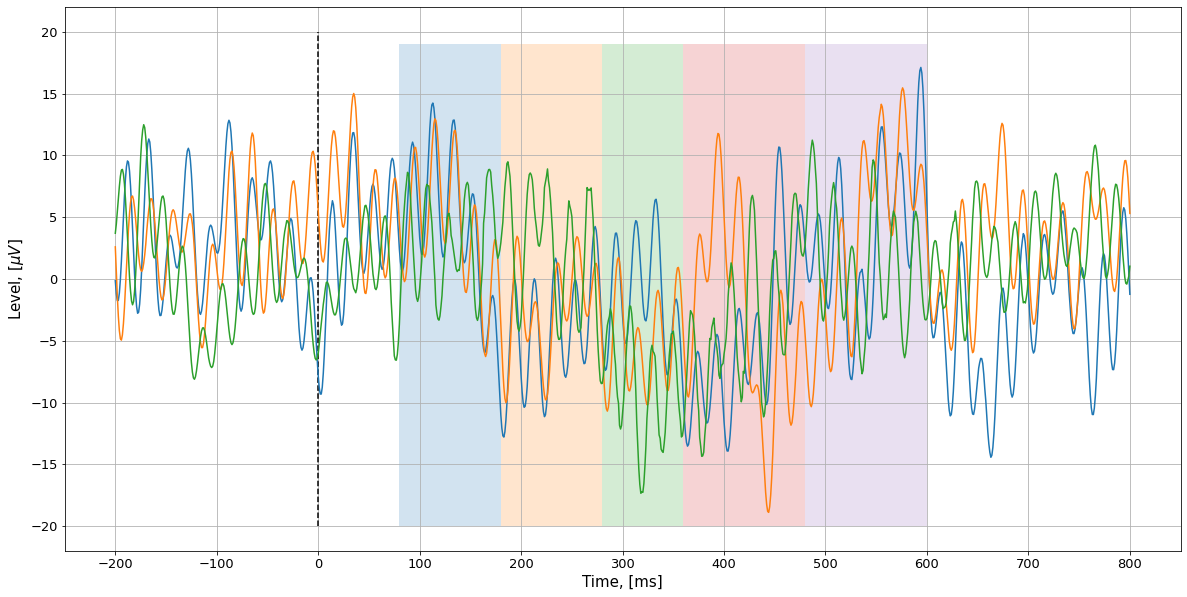

In [33]:
# plot after filtering for S01
plt.figure(figsize=(20, 10))

plt.plot(Spivot01_f_T['Time'], Spivot01_f_T[0])
plt.plot(Spivot01_f_T['Time'], Spivot01_f_T[1])
plt.plot(Spivot01_f_T['Time'], Spivot01_f_T[2])

plt.vlines(0, -20, 20, colors='black', linestyles='dashed')

plt.grid()
plt.xlabel('Time, [ms]', size='15')
plt.ylabel('Level, [$\mu V$]', size='15')

y = np.arange(-20, 20)
plt.fill_betweenx(y,  80, 180, alpha=0.2)
plt.fill_betweenx(y, 180, 280, alpha=0.2)
plt.fill_betweenx(y, 280, 360, alpha=0.2)
plt.fill_betweenx(y, 360, 480, alpha=0.2)
plt.fill_betweenx(y, 480, 600, alpha=0.2)

plt.yticks(fontsize=13)
plt.xticks(np.arange(-200, 801, step=100), fontsize=13)

plt.show()

In [31]:
eeg17.load_data()
raw_df17_f = eeg17.filter(1., 50., fir_design='firwin', skip_by_annotation='edge')

raw_df17_f = raw_df17_f.to_data_frame()
raw_df17_f.drop('time', axis = 1, inplace = True)
                         
mask = ((raw_df17 <= 50) & (raw_df17 >= -50)) # удаление данных более 50 uV и менее -50uV
raw_df17_f = raw_df17_f[mask]
raw_df17_f = raw_df17_f.fillna(method='ffill')
raw_df17_f = raw_df17_f.fillna(method='bfill')

raw_df17_f['level'] = raw_df17_f.mean(axis=1)
raw_df_mean17_f = raw_df17_f['level']
raw_df_mean17_f = raw_df_mean17_f.to_frame()
raw_df_mean17_f['time'] = raw_df_mean17_f.index
raw_df_mean17_f

S17_f = raw_df_mean17_f.join(Events17.set_index('time'), on='time')
S17_f = S17_f.dropna(axis=0, how='any')
S17_f = S17_f.reset_index(drop = True)

S17_f['epochs'] = pd.DataFrame(np.repeat(np.arange(0, 200), 1001))
S17_f.loc[(S17_f.intervals == 'Tmin'), 'intervals'] = '0' 
S17_f.loc[(S17_f.intervals == 'Tmax'), 'intervals'] = '1000' 
S17_f['intervals'] = S17_f['intervals'].astype(int)

Spivot17_f = S17_f.pivot(index='epochs', columns='intervals', values='level')
Spivot17_f_T = Spivot17_f.T

Spivot17_f_T['Time'] = pd.DataFrame(np.arange(-200, 1000))
Spivot17_f_T = Spivot17_f_T.reset_index(drop = True)
Spivot17_f_T

Reading 0 ... 2002999  =      0.000 ...  2002.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 sec)



epochs,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Time
0,-17.921198,-23.439795,-18.045708,-19.774456,-20.046397,-22.705084,18.424664,22.654182,4.274370,-17.394946,...,37.368193,35.951334,-4.242646,18.317430,4.838318,-29.086679,-35.022150,-13.170448,-39.342923,-200
1,-17.894551,-23.411298,-18.027178,-19.745228,-20.022060,-22.710829,18.406490,22.660855,18.688423,19.085790,...,39.603467,38.413809,-19.216753,27.274906,18.146823,-13.401640,-28.384777,-24.552528,-32.940620,-199
2,-17.863867,-23.775864,-18.001758,-19.713054,-19.993236,-22.706910,18.381278,22.657656,18.703757,21.066002,...,39.834990,38.792027,-27.261883,31.334688,26.428452,5.229781,-14.094993,-30.017691,-18.485123,-198
3,-15.916118,10.057501,-17.971981,-22.084830,-20.115206,-22.693674,18.351463,22.644817,18.710076,21.072784,...,34.882704,34.807774,-31.271131,34.611524,30.884692,19.149969,3.261482,-32.148674,-0.271223,-197
4,8.154512,13.311625,-18.610109,16.956655,-12.540468,-22.672381,18.403970,22.623484,18.706860,21.071218,...,19.446325,20.372314,-34.762167,38.043802,34.403107,27.078190,16.251077,-34.811742,14.077138,-196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-15.778329,-26.404022,-17.018763,-12.591673,-16.897703,22.446163,18.869941,-17.242107,-17.198874,-17.368053,...,-2.586004,-0.301669,42.068684,-36.242457,-40.956010,-29.456714,-24.631464,40.865916,-18.851003,796
997,-15.789810,-26.405481,-20.201910,-12.602845,-16.913416,22.599918,24.906759,-17.344709,-17.176624,-17.342594,...,15.227996,15.684320,41.926747,-35.814061,-41.300887,-33.183116,-30.507411,40.301112,-24.607692,797
998,-15.792114,-26.397670,-20.216151,-12.605028,-16.920916,1.706455,24.919487,-12.255722,-17.149804,-17.312275,...,26.343020,26.681161,40.900541,-32.544626,-36.435709,-36.709227,-34.207026,35.622395,-28.234762,798
999,-15.784943,-26.381484,-20.222008,-12.598087,-16.919553,-17.581401,24.922713,13.789977,-17.919791,-17.279955,...,31.389814,32.911110,34.587797,-19.681060,-22.957143,-38.729675,-37.231848,22.565150,-31.335828,799


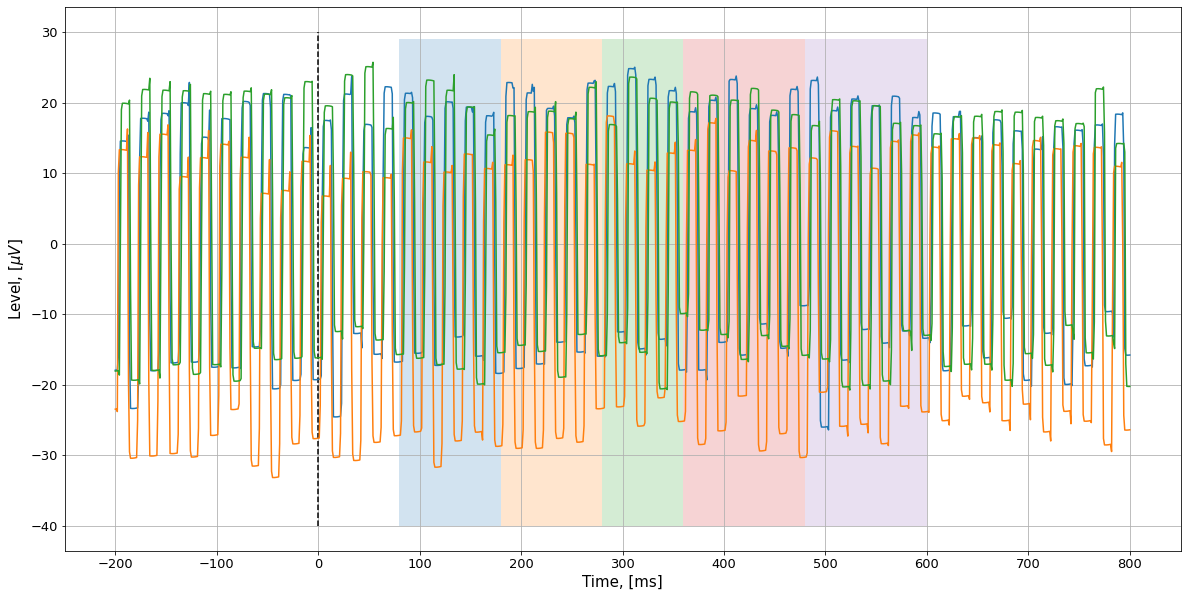

In [32]:
# plot after filtering for S17
plt.figure(figsize=(20, 10))

plt.plot(Spivot17_f_T['Time'], Spivot17_f_T[0])
plt.plot(Spivot17_f_T['Time'], Spivot17_f_T[1])
plt.plot(Spivot17_f_T['Time'], Spivot17_f_T[2])

plt.vlines(0, -40, 30, colors='black', linestyles='dashed')

plt.grid()
plt.xlabel('Time, [ms]', size='15')
plt.ylabel('Level, [$\mu V$]', size='15')

y = np.arange(-40, 30)
plt.fill_betweenx(y,  80, 180, alpha=0.2)
plt.fill_betweenx(y, 180, 280, alpha=0.2)
plt.fill_betweenx(y, 280, 360, alpha=0.2)
plt.fill_betweenx(y, 360, 480, alpha=0.2)
plt.fill_betweenx(y, 480, 600, alpha=0.2)

plt.yticks(fontsize=13)
plt.xticks(np.arange(-200, 801, step=100), fontsize=13)

plt.show()

In [ ]:
###################

In [37]:
# features extraction

In [65]:
# ERP S01
signal01_ERN  = Spivot01_f_T.iloc[:, 280:381]
signal01_P200 = Spivot01_f_T.iloc[:, 380:481]
signal01_FRN  = Spivot01_f_T.iloc[:, 480:561]
signal01_P300 = Spivot01_f_T.iloc[:, 560:781]
signal01_N500 = Spivot01_f_T.iloc[:, 780:801]

In [ ]:
##############
# комментарии и вопросы
# 1. я показал два файла с событиями (200 событий), каждый состоит из 1001 точки-измерения - для набора данных S01 и S17
# 2. данные не усреднял
# 3. нужно выделить признаки в каждом из пяти интервалов, указанных выше (ERP), отдельно (разделение на блоки по строкам не работает. что не так?)
# 4. как быть с файлом S17? фильтровать ica? если да, то нужно ли выполнить ica для всех 20 файлов?
# 5. выполняя ica через mne пакет не понятно, как получить данные после выполнения функции в таблицу?
# 6. после выполнения всех преобразований - FFT, PSD, DWT мы получаем коэффициенты. как их получить в виде таблицы?